In [2]:
%matplotlib inline

In [3]:
import io
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats
import scipy.special
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook')

In [4]:
"""

PROBLEM STATEMENT:

What impact does alcohol consumption have on the fertility diagnoses (sperm concentration) 
of males (keeping in mind that sperm concentration are related to socio-demographic and 
environmental factors, health status, as well as habits accosicated with individual lifestyle)?
"""

##################################################################################################
##################################################################################################

"""Stripped down dataset to include just relevant data: alcohol consumption and diagnosis outcome."""

data = """Alcohol Consumption (frequency)	FertilityDiagnosis
0.8	N
0.8	O
1	N
1	N
0.8	O
0.8	N
0.8	N
0.6	N
0.8	N
1	N
0.8	N
0.6	N
0.8	N
1	N
0.2	N
1	N
1	N
0.8	O
1	N
0.8	O
0.8	N
0.6	N
0.8	N
1	O
1	N
1	N
0.6	O
0.6	O
1	N
0.6	O
1	N
1	N
1	N
0.8	N
1	N
0.6	N
1	N
1	N
0.6	O
1	N
0.8	N
0.8	N
0.8	N
1	N
1	N
1	N
1	N
0.6	N
0.8	N
0.6	N
0.8	N
1	N
0.8	N
0.8	N
1	N
0.8	N
0.8	N
1	N
0.4	N
0.8	N
0.8	N
1	N
0.6	N
1	N
0.8	N
1	N
0.8	N
1	N
0.8	N
0.8	N
0.8	O
1	N
0.6	N
0.8	N
0.8	N
1	N
0.6	N
0.8	N
0.8	N
0.6	N
1	N
0.8	N
0.6	N
1	N
1	O
0.6	N
0.6	N
0.8	N
1	N
1	N
0.8	N
1	N
0.8	N
0.8	O
0.6	N
1	N
0.8	N
1	N
1	N
0.6	N
"""
df = pd.read_table(io.StringIO(data))
df.FertilityDiagnosis = df.FertilityDiagnosis == 'O'
df.head(10)

,Alcohol Consumption (frequency),FertilityDiagnosis
0,0.8,False
1,0.8,True
2,1.0,False
3,1.0,False
4,0.8,True
5,0.8,False
6,0.8,False
7,0.6,False
8,0.8,False
9,1.0,False


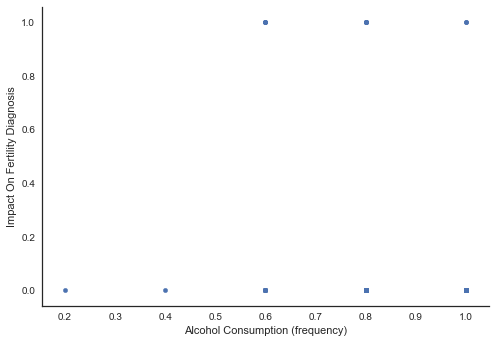

In [5]:
"""

Frequency of alcohol consumption is measured (0, 1) with the following criteria: 
    
    1. Several times a day
    2. Every day
    3. Several times a week
    4. Once a week
    5. Hardly ever or never
    

Fertility Output s as follows: 
    
    1. Diagnosis normal (N)
    2. Altered (by the aforementioned factor) (O) 

"""
"""Plot the Data"""

df.plot.scatter('Alcohol Consumption (frequency)', 'FertilityDiagnosis')
plt.ylabel('Impact On Fertility Diagnosis')
sns.despine()

In [6]:
import sklearn.linear_model

In [7]:
"""
Address unpenalized OLS, etc. associated with regression. 
C=1e12 is effectively no regularization - see https://github.com/scikit-learn/scikit-learn/issues/6738.
"""

clf = sklearn.linear_model.LogisticRegression(C=1e12, random_state=0)
clf.fit(df['Alcohol Consumption (frequency)'].values.reshape(-1, 1), df['FertilityDiagnosis'])
print(clf.intercept_, clf.coef_)

[-0.03588022] [[-2.42830288]]


In [8]:
def plot_log_reg(x, y, data, clf, xmin=None, xmax=None, alpha=1, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure
    ax.scatter(data[x], data[y], color='black', zorder=20, alpha=alpha)
    if xmin is None:
        xmin = x.min()
    if xmax is None:
        xmax = x.max()
    X_test = np.linspace(xmin, xmax, 300)

    loss = scipy.special.expit(X_test * clf.coef_ + clf.intercept_).ravel()
    ax.plot(X_test, loss, linewidth=3)

    ax.set_xlabel(x)
    ax.set_ylabel(y)
    fig.tight_layout()
    sns.despine()
    return fig, ax

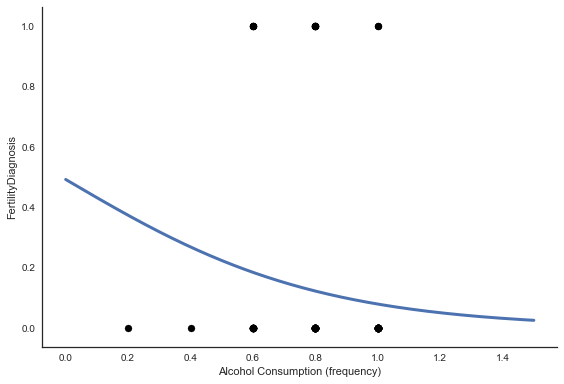

In [9]:
"""Plot Data"""

plot_log_reg(x='Alcohol Consumption (frequency)', y='FertilityDiagnosis', data=df, clf=clf, xmin=0, xmax=1.5);

In [10]:
def log_reg_null_model(y):
    clf = sklearn.linear_model.LogisticRegression(C=1e12)
    clf.fit(np.zeros_like(y).reshape(-1, 1), y)
    return clf

clf0 = log_reg_null_model(df['FertilityDiagnosis'])

In [11]:
import sklearn.metrics

In [12]:
def log_reg_lik_ratio_test(X, Y, clf0, clf1, df=1):
    if X.ndim == 1:
        X = X.values.reshape(-1, 1)
    y_prob0 = clf0.predict_proba(X)
    loss0 = sklearn.metrics.log_loss(Y, y_prob0, normalize=False)
    y_prob1 = clf1.predict_proba(X)
    loss1 = sklearn.metrics.log_loss(Y, y_prob1, normalize=False)
    D = 2 * (loss0 - loss1)
    return scipy.stats.distributions.chi2.sf(D, df=df)

In [13]:
log_reg_lik_ratio_test(df['Alcohol Consumption (frequency)'], df['FertilityDiagnosis'].astype(np.float64), clf0, clf)

0.16248345977701148

In [14]:
_ = clf.predict_proba(df['Alcohol Consumption (frequency)'].values.reshape(-1, 1))
df['prob_absent'], df['prob_present'] = _[:,0], _[:,1]
lik = df.loc[df['FertilityDiagnosis'], 'prob_present'].prod() * df.loc[~df['FertilityDiagnosis'], 'prob_absent'].prod()
print(
    -np.log(lik), 
    sklearn.metrics.log_loss(
        df['FertilityDiagnosis'], 
        clf.predict_proba(df['Alcohol Consumption (frequency)'].values.reshape(-1, 1)), 
        normalize=False
    )
)

35.7170192231 35.7170192231


In [ ]:
"""
CONCLUSIONS:

The frequency of alcohol consumption has no particular bearing on the fertility diagnois (sperm concentration) in males.

###############################################################################

Predicting Fertility Diagnosis in Drinkers

Abstract: 

100 volunteers provide a semen sample analyzed according to the WHO 2010 criteria. Sperm concentration are related to socio-demographic data, environmental factors, health status, and life habits.
Problem Statement: 
What impact does alcohol consumption have on the fertility diagnoses (sperm concentration) of males (keeping in mind that sperm concentration are related to socio-demographic and environmental factors, health status, as well as habits accosicated with individual lifestyle)?

###############################################################################

Data Set Information:

The data associated with this analysis (http://archive.ics.uci.edu/ml/datasets/Fertility) contains the following information:
0. Season in which the analysis was performed. 1) winter, 2) spring, 3) Summer, 4) fall. (-1, -0.33, 0.33, 1)
1. Age at the time of analysis. 18-36 (0, 1)
2. Childish diseases (ie , chicken pox, measles, mumps, polio) 1) yes, 2) no. (0, 1)
3. Accident or serious trauma 1) yes, 2) no. (0, 1)
4. Surgical intervention 1) yes, 2) no. (0, 1)
5. High fevers in the last year 1) less than three months ago, 2) more than three months ago, 3) no. (-1, 0, 1)
6. Frequency of alcohol consumption 1) several times a day, 2) every day, 3) several times a week, 4) once a week, 5) hardly ever or never (0, 1)
7. Smoking habit 1) never, 2) occasional 3) daily. (-1, 0, 1)
8. Number of hours spent sitting per day ene-16 (0, 1)
9. Output: Diagnosis normal (N), altered (O) 

###############################################################################

Relevant Papers:

David Gil, Jose Luis Girela, Joaquin De Juan, M. Jose Gomez-Torres, and
Magnus Johnsson. Predicting seminal quality with artificial intelligence
methods. Expert Systems with Applications, 39(16):12564 - 12573, 2012.

###############################################################################

Citations:

David Gil, Jose Luis Girela, Joaquin De Juan, M. Jose Gomez-Torres, and
Magnus Johnsson. Predicting seminal quality with artificial intelligence
methods. Expert Systems with Applications, 39(16):12564 - 12573, 2012.

"""